# Sujet 6 : Autour du Paradoxe de Simpson

## Contexte de l'étude

Cette étude porte sur le [Paradoxe de Simpson](https://fr.wikipedia.org/wiki/Paradoxe_de_Simpson) (Simpson 1951, Undy 1903). Ce paradoxe est un paradoxe statistique "dans lequel un phénomène observé de plusieurs groupes semble s'inverser lorsque les groupes sont combinés. Ce résultat qui semble impossible au premier abord est lié à des éléments qui ne sont pas pris en compte (comme la présence de variables non indépendantes ou de différences d'effectifs entre les groupes, etc.) est souvent rencontré dans la réalité, en particulier dans les sciences sociales et les statistiques médicales" (Wikipédia). 

Pour représenter ce paradoxe, on utilisera les données d'un sondage des années 1970 d'une ville du nord-est de l'Angleterre sur un sixième des électeurs, complété par une seconde étude 20 ans plus tard (Vanderpump et al. 1995) sur les mêmes personnes. Le sondage initial avait été réalisé afin d'expliciter les travaux sur les maladies thyroïdiennes et cardiaques (Tunbridge et al. 1977). Le second sondage avait pour objectif de savoir si les individus étaient envore en vie, notamment au vu de leur tabagisme.

Pour ce MOOC : "Nous nous restreindrons aux femmes et parmi celles-ci aux 1314 qui ont été catégorisées comme "fumant
actuellement" ou "n'ayant jamais fumé". Il y avait relativement peu de femmes dans le sondage initial ayant fumé et ayant arrêté depuis (162) et très peu pour lesquelles l'information n'était pas disponible (18). La survie à 20 ans a été déterminée pour l'ensemble des femmes du premier sondage" (MOOC Recherche Reproductible).

## Importation des librairies python

In [146]:
import os
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import logit
%matplotlib inline

# Supprime l'affichage des UserWarnings avec toutes les dépréciations de fonctions
import warnings 
warnings.simplefilter('ignore')

## Traitement des données

Les donnés sont disponibles sur le GitLab du MOOC Reproductibilité. Par soucis d'accessibilité et pour éviter toute disparition de données suite à la fermeture du MOOC, on enregistrera les données récupérées de manière locale. Elles seront uniquement téléchargées si la copie locale n'existe pas.


In [6]:
data_url = 'https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/-/raw/master/module3/Practical_session/Subject6_smoking.csv?inline=false'
data_file = 'simpson_paradox.csv'

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

Chaque ligne des données représente une personne avec comme information:
- Si la personne fume (Yes/No)
- Si elle est vivante ou morte au moment de la 2ème étude (Alive/Dead)
- Son âge au 1er sondage (arrondi à la 1ère décimale)

In [173]:
data = pd.read_csv(data_url)
data

Smoker Status   Age
0       Yes  Alive  21.0
1       Yes  Alive  19.3
2        No   Dead  57.5
3        No  Alive  47.1
4       Yes  Alive  81.4
5        No  Alive  36.8
6        No  Alive  23.8
7       Yes   Dead  57.5
8       Yes  Alive  24.8
9       Yes  Alive  49.5
10      Yes  Alive  30.0
11       No   Dead  66.0
12      Yes  Alive  49.2
13       No  Alive  58.4
14       No   Dead  60.6
15       No  Alive  25.1
16       No  Alive  43.5
17       No  Alive  27.1
18       No  Alive  58.3
19      Yes  Alive  65.7
20       No   Dead  73.2
21      Yes  Alive  38.3
22       No  Alive  33.4
23      Yes   Dead  62.3
24       No  Alive  18.0
25       No  Alive  56.2
26      Yes  Alive  59.2
27       No  Alive  25.8
28       No   Dead  36.9
29       No  Alive  20.2
...     ...    ...   ...
1284    Yes   Dead  36.0
1285    Yes  Alive  48.3
1286     No  Alive  63.1
1287     No  Alive  60.8
1288    Yes   Dead  39.3
1289     No  Alive  36.7
1290     No  Alive  63.8
1291     No   Dead  71.3
1292     No  Alive  57.7
1293     No  Alive  63.2
1294     No  Alive  46.6
1295    Yes   Dead  82.4
1296    Yes  Alive  38.3
1297    Yes  Alive  32.7
1298     No  Alive  39.7
1299    Yes   Dead  60.0
1300     No   Dead  71.0
1301     No  Alive  20.5
1302     No  Alive  44.4
1303    Yes  Alive  31.2
1304    Yes  Alive  47.8
1305    Yes  Alive  60.9
1306     No   Dead  61.4
1307    Yes  Alive  43.0
1308     No  Alive  42.1
1309    Yes  Alive  35.9
1310     No  Alive  22.3
1311    Yes   Dead  62.1
1312     No   Dead  88.6
1313     No  Alive  39.1

[1314 rows x 3 columns]

On vérifir que toutes nos lignes sont bien remplies et que les âges sont cohérents

In [9]:
 data[data.isnull().any(axis=1)]

Empty DataFrame
Columns: [Smoker, Status, Age]
Index: []

In [10]:
print('Ages minimaux et maximaux: ' + str([data.Age.min(), data.Age.max()]))

Ages minimaux et maximaux: [18.0, 89.9]


## Etudes

### Décès en fonction des habitudes de tabagisme

Le tableau suivant récapitule le nombre de femmes mortes ou vivantes selon sa relation au tabac.

In [33]:
data_death = data.groupby(['Smoker'])['Status'].value_counts().unstack()
data_death['Mortality'] = round(data_death['Dead'] / (data_death['Dead'] + data_death['Alive']), 3) 
data_death

Status  Alive  Dead  Mortality
Smoker                        
No        502   230      0.314
Yes       443   139      0.239

On peut afficher graphiquement les données de ce tableau:

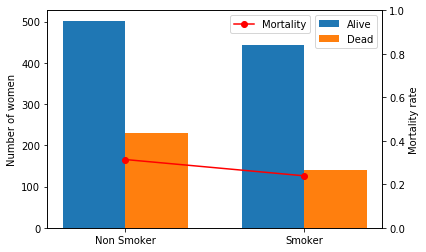

In [42]:
x = np.arange(2)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x - width/2, data_death['Alive'], width, label='Alive')
ax.bar(x + width/2, data_death['Dead'], width, label='Dead')
ax2 = ax.twinx()
ax2.plot(x, data_death['Mortality'], color='r', marker='o', label='Mortality')

ax.set_ylabel('Number of women')
ax2.set_ylabel('Mortality rate')
ax2.set_ylim(0,1)
ax.set_xticks(x)
ax.set_xticklabels(['Non Smoker', 'Smoker'])
ax.legend()
ax2.legend(bbox_to_anchor=(0.8, 1))

A partir de ces graphiques et résultats il serait logique de conclure que les non fumeuses ont une mortalité plus importante (31%) par rapport aux fumeuses (24%) et que donc fumer aide à vivre longtemps. Même en regardant les intervales de confiance sur la condition (morte **1** ou vivante **0**) de la personne suivant son statut de fumeur nous indique que les fumeurs ont plus de chance de survie.

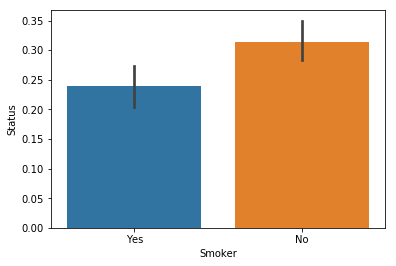

In [258]:
sns.barplot(x='Smoker', y='Status', ci=95, data=data.replace('Alive', 0).replace('Dead', 1))

Mais il est de connaissance publique que "fumer tue". **Alors comment les données nous trompent-elles ?** Nous avons regardé les données de manière globale sans rentrer dans les détails. Si l'on regarde l'âge des femmes suivant leur statut de fumeur un paradoxe commence à apparaître:

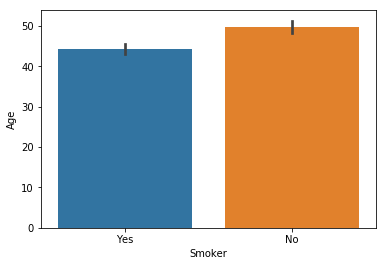

In [259]:
sns.barplot(x='Smoker', y='Age', ci=95, data=data)

La prochaine étape est donc d'étudier les données plus précisément, notamment suivant les tranches d'âges.

## Décès liés au tabagisme suivant l'âge

En reprenant les données précédentes et en rajoutant une catégorie d'âge (18-34 ans, 34-54 ans, 55-64 ans, plus de 65 ans), on réalise les mêmes analyses.

In [260]:
tranche_age = [18, 34, 54, 64, 100]

col_tranche = pd.cut(data['Age'], tranche_age)
data_age = data.groupby(col_tranche).apply(lambda x: x.groupby(['Smoker'])['Status'].value_counts().unstack())
data_age['Mortality'] = (data_age['Dead'].values / (data_age['Dead'].values + data_age['Alive'].values)).round(3) 
data_age

Status            Alive  Dead  Mortality
Age       Smoker                        
(18, 34]  No        212     6      0.028
          Yes       172     5      0.028
(34, 54]  No        180    19      0.095
          Yes       196    41      0.173
(54, 64]  No         81    40      0.331
          Yes        64    51      0.443
(64, 100] No         28   165      0.855
          Yes         7    42      0.857

A partir de ce tableau on peut afficher les données:

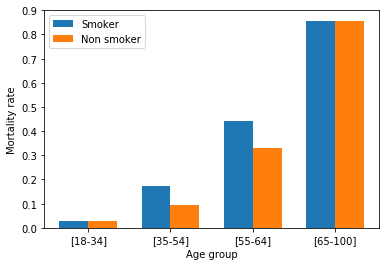

In [261]:
# Visualisation du taux de mortalité suivant les âges et le statut de fumeur

tranche_age_label = ['[18-34]', '[35-54]', '[55-64]', '[65-100]']  # the label text
x = np.arange(len(tranche_age_label))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
ax.bar(x - width/2, data_age.reset_index()[data_age.reset_index().Smoker == 'Yes']['Mortality'], width, label='Smoker')
ax.bar(x + width/2, data_age.reset_index()[data_age.reset_index().Smoker == 'No']['Mortality'], width, label='Non smoker')

ax.set_ylabel('Mortality rate')
ax.set_xlabel("Age group")
ax.set_xticks(x)
ax.set_xticklabels(tranche_age_label)
ax.legend()

On remarque sur le graphique ci-dessus que finalement pour chaque classe d'âge le taux de mortalité chez les fumeuses est supérieur ou égal à celui des non fumeuses !

En s'intéressant à l'histogramme des âges chez ces deux populations ci-dessous, on s'aperçoit qu'il y a plus de non fumeuses d'âge supérieur à 65ans, qui ont donc plus de chance de décéder naturellement. Cette tranche est donc sur-représentée chez les non-fumeuses, amenant en moyenne à un taux de mortalité plus élevé.

**Etudier des données dans leur ensemble peut donner des résultats très différents par rapport à des études sur des sous-groupes. Cela peut amener à des erreurs d'interprétation importantes.**

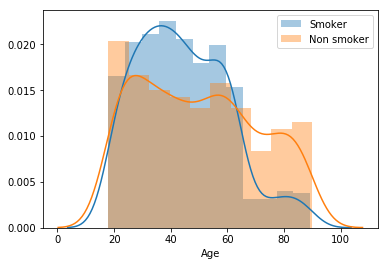

In [262]:
# Visualisation du nombre de femmes vivantes et décédées par tranche d'âge

sns.distplot(data[data.Smoker == 'Yes']['Age'], label='Smoker', kde=True)
sns.distplot(data[data.Smoker == 'No']['Age'], label='Non smoker')
plt.legend()

Ainsi 2 conclusions peuvent être tirées sur ce biais d'étude:
- Ce biais arrive notamment à cause de la **non homogénéité de l'échantillon**. On voit bien ci-dessus que toutes les tranches d'âge ne sont pas représentées de la même manière si les femmes sont fumeuses ou non fumeuses. Il faut cependant faire attention à étudier des *tranches d'âge régulières et adaptés à l'étude*.
- De plus, dans la 1ère partie l'âge des participantes avait été mis de côté au profit d'une moyenne sur l'ensemble. Cette **mise à l'écart de ce paramètre** a induit une mauvaise interprétation.



## Décès et régression logistique

En dernière partie une régression logistique est réalisée afin de supprimer le biais induit par des tranches d'âges arbitraires et non régulières.

Tout d'abord une nouvelle colonne est créée avec :
- Si la femme est décédée: 1
- Si la femme est vivante: 0


In [263]:
data_reg = data.replace('Alive', 0).replace('Dead', 1)

print ('Exemple :')
data_reg.loc[0:10, ]

Exemple :


Smoker  Status   Age
0     Yes       0  21.0
1     Yes       0  19.3
2      No       1  57.5
3      No       0  47.1
4     Yes       0  81.4
5      No       0  36.8
6      No       0  23.8
7     Yes       1  57.5
8     Yes       0  24.8
9     Yes       0  49.5
10    Yes       0  30.0

On réalise pour chacun des groupes *'Smoker'* et *'Non smoker'* une régresion logistique pour visualiser la corrélation entre l'âge et le décès (et donc la probabilité de décès en fonction de l'âge).

In [264]:
# Pour les Fumeuses
data_reg_smoker = data_reg[data_reg.Smoker == 'Yes']
model = logit('Status ~ Age', data=data_reg_smoker)
result_smoker = model.fit() #algorithme de Newton-Raphson par défaut
logit_smoker = result_smoker.predict(data_reg_smoker)  # predictions
result_smoker.summary()

Optimization terminated successfully.
         Current function value: 0.412727
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                  582
Model:                          Logit   Df Residuals:                      580
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                  0.2492
Time:                        15:23:47   Log-Likelihood:                -240.21
converged:                       True   LL-Null:                       -319.94
                                        LLR p-value:                 1.477e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.5081      0.466    -11.814      0.000      -6.422      -4.594
Age            0.0890      0.009     10.203      0.000       0.072       0.106
==============================================================================
"""

Pour les fumeuses on voit que l'âge est un paramètre statistiquement important (P < 0.05), avec un coefficient de pente de 0.089 (avec une erreur de 10%), compris pour un CI de 2.5% entre 0.106 et 0.072.

In [265]:
# Pour les non Fumeuses

data_reg_nosmoker = data_reg[data_reg.Smoker == 'No']
model = logit('Status ~ Age', data=data_reg_nosmoker)
result_nosmoker = model.fit()
logit_nosmoker = result_nosmoker.predict(data_reg_nosmoker) 
result_nosmoker.summary()

Optimization terminated successfully.
         Current function value: 0.354560
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                  732
Model:                          Logit   Df Residuals:                      730
Method:                           MLE   Df Model:                            1
Date:                Fri, 31 Jul 2020   Pseudo R-squ.:                  0.4304
Time:                        15:23:49   Log-Likelihood:                -259.54
converged:                       True   LL-Null:                       -455.62
                                        LLR p-value:                 2.808e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7955      0.479    -14.174      0.000      -7.735      -5.856
Age            0.1073      0.008     13.742      0.000       0.092       0.123
==============================================================================
"""

Pour les non-fumeuses on voit que l'âge est un paramètre statistiquement important (P < 0.05), avec un coefficient de pente de 0.1073 (avec une erreur de moins de 10%, suffisamment faible pour comparer avec les résultats des fumeuses), compris pour un CI de 2.5% entre 0.123 et 0.092. Ce coefficient est plus élevé que pour les femmes fumeuses, avec cependant un coefficient d'interception plus important.

Afin de mieux visualiser cette variation en fonction de l'âge, les fonctions logistiques sont tracées. Seaborn utilisant le package statsmodel pour la fonction lmplot, il est possible de l'utiliser pour visualiser de manière simple les deux courbes sur un même graphe avec les intervales de confiance pour chacune des courbes.

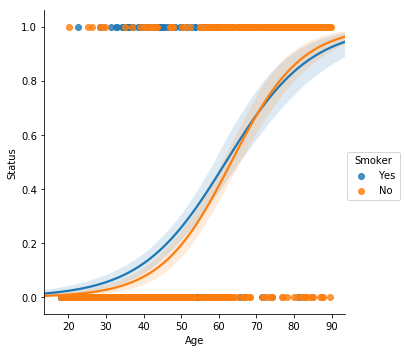

In [268]:
sns.lmplot('Age', 'Status', data=data_reg, logistic=True, ci=97.5, hue='Smoker')

A partir des données précédentes il est possible de voir : 
- Pour des âges entre 35 et 60 ans, il y a plus de probabilité de décès pour les fumeuses que les non-fumeuses
- Pour des âges plus élevés les courbes se rejoignent et les intervalles de confiance se recoupent, ne permettant pas de conclure sur des probabilités plus fortes de décès dans l'un ou l'autre des cas.
- Le coefficient de régression des non-fumeuses est plus élevé avec une interception négative plus grande notamment parce que la probabilité de décès augmente fortement au-delà de 60 ans, comparativement à celle des non-fumeuses qui augmente de manière plus constante.

**Ainsi ces régressions nous montre que l'effet du tabagisme est important pour une certaine tranche d'âge mais qu'au delà d'autres causes de décès entrent en jeu alignant le nombre de mort de manière identique entre les deux status.**
